In [33]:
from pathlib import Path
import json
import numpy as np

# Project root: repo_root/notebooks/01_generate_shapes_images.ipynb
ROOT = Path("..").resolve()

# Choose ONE input:
# INPUT = ROOT / "data" / "mats" / "dog_343_occ.mat"
# INPUT = ROOT / "data" / "mats" / "master_lib.mat"
GENERATED_MAT = ROOT / "data" / "mats" / "dog_3.jsonl"   # example
MASTER_LIB    = ROOT / "data" / "mats" / "master_lib.mat" 

OUT_DIR = ROOT / "data" / "generated_images_dog_3"
WITH_OCC_DIR = OUT_DIR / "with_occluder"
NO_OCC_DIR = OUT_DIR / "no_occluder"
RAND_DIR = OUT_DIR / "completions"

for d in [WITH_OCC_DIR, NO_OCC_DIR, RAND_DIR]:
    d.mkdir(parents=True, exist_ok=True)

H = 600
W = 900
MARGIN = 5
SUPERSAMPLE = 4

SEED = 1000083
rng = np.random.default_rng(SEED)

print("ROOT:", ROOT)
print("INPUT:", GENERATED_MAT)
print("OUT_DIR:", OUT_DIR)

import sys
sys.path.append(str(ROOT / "scripts"))

from shape_gen.io_mat import load_generated_case, unit_to_pixel


def load_case_from_jsonl(jsonl_path: Path, *, line_index: int = -1, default_baseGrid: int = 256):
    """
    Accepts TWO JSONL schemas:

    A) Pipeline schema (preferred):
       silhouette_u, occluder_u, baseGrid, sil_class

    B) Your current schema:
       shape_contour_xy, occluder_rect_xy, (optional) coord_system, (optional) H/W
       . We'll treat these as unit coords and set baseGrid = default_baseGrid unless present.
    """
    lines = jsonl_path.read_text(encoding="utf-8").splitlines()
    if not lines:
        raise ValueError(f"Empty JSONL: {jsonl_path}")
    row = json.loads(lines[line_index])

    # --- Schema A ---
    if "silhouette_u" in row:
        silhouette_u = np.asarray(row["silhouette_u"], dtype=np.float64)
        occluder_u = np.asarray(row.get("occluder_u", []), dtype=np.float64)
        baseGrid = int(row["baseGrid"])
        sil_class = row.get("sil_class", None)

        if occluder_u.size == 0:
            occluder_u = np.zeros((0, 2), dtype=np.float64)

        return silhouette_u, occluder_u, baseGrid, sil_class, row

    # --- Schema B (your current JSONL) ---
    if "shape_contour_xy" in row:
        silhouette_u = np.asarray(row["shape_contour_xy"], dtype=np.float64)
        occluder_u = np.asarray(row.get("occluder_rect_xy", []), dtype=np.float64)

        # Use baseGrid if present, else fall back.
        baseGrid = int(row.get("baseGrid", default_baseGrid))

        # Optional: if your JSONL stores H/W, you might want baseGrid=H (if square)
        if "H" in row and "W" in row and int(row["H"]) == int(row["W"]):
            baseGrid = int(row.get("baseGrid", row["H"]))

        sil_class = row.get("sil_class", row.get("category", None))

        if occluder_u.size == 0:
            occluder_u = np.zeros((0, 2), dtype=np.float64)

        return silhouette_u, occluder_u, baseGrid, sil_class, row

    raise KeyError(
        f"JSONL row missing expected keys. Found keys: {sorted(row.keys())}. "
        f"Expected either 'silhouette_u' or 'shape_contour_xy'."
    )


def load_case_unified(input_path: Path):
    """
    Returns:
      silhouette_u, occluder_u, baseGrid, sil_class, meta(dict)
    """
    input_path = Path(input_path)

    if input_path.suffix.lower() == ".jsonl":
        silhouette_u, occluder_u, baseGrid, sil_class, meta = load_case_from_jsonl(input_path)
        meta["source_type"] = "jsonl"
        return silhouette_u, occluder_u, baseGrid, sil_class, meta

    if input_path.suffix.lower() == ".mat":
        # generated case .mat (your existing format)
        case = load_generated_case(input_path)
        meta = {"source_type": "mat", "source_mat": str(input_path)}

        silhouette_u = case.silhouette_u
        occluder_u = case.occluder_u
        baseGrid = case.base_grid
        sil_class = case.sil_class

        return silhouette_u, occluder_u, baseGrid, sil_class, meta

    raise ValueError(f"Unsupported input type: {input_path.suffix}")


silhouette_u, occluder_u, baseGrid, sil_class, meta = load_case_unified(GENERATED_MAT)

silhouette = unit_to_pixel(silhouette_u, baseGrid)
occluder = unit_to_pixel(occluder_u, baseGrid) if occluder_u.size else np.zeros((0, 2), dtype=np.int32)

print("meta:", meta)
print("baseGrid:", baseGrid)
print("silhouette_u:", silhouette_u.shape, float(np.min(silhouette_u)), float(np.max(silhouette_u)))
print("occluder_u:", occluder_u.shape)
print("silhouette:", silhouette.shape, silhouette.dtype)
print("occluder:", occluder.shape, occluder.dtype)
print("sil_class:", sil_class)


ROOT: /Users/I743312/Documents/occlusion-study
INPUT: /Users/I743312/Documents/occlusion-study/data/mats/dog_3.jsonl
OUT_DIR: /Users/I743312/Documents/occlusion-study/data/generated_images_dog_3
meta: {'ts_utc': 1769270720.001146, 'source_mat': '/Users/I743312/Documents/occlusion-study/data/mats/master_lib.mat', 'category': 'dog', 'img_id': 3, 'coord_system': 'normalized_contour_space', 'shape_contour_xy': [[0.08882165018907465, 0.26656970011591374], [0.09712788095335849, 0.2725577446723283], [0.10404973992359502, 0.27911921480120405], [0.11127480416379648, 0.2845665334385287], [0.12175186902568916, 0.28595090523257605], [0.13084456209353457, 0.28871964882067064], [0.14074820138296612, 0.29148839240876523], [0.15122526624485877, 0.29287276420281255], [0.16112890553429035, 0.29564150779090714], [0.17128191792023056, 0.2978082114673195], [0.18150960968561455, 0.29979462317304906], [0.19002887718099878, 0.303947738555191], [0.19993251647043034, 0.3067164821432856], [0.2090252095382757, 0.

In [34]:
from shape_gen.geom_bbox import compute_bbox

polys_for_bbox = [silhouette]
if occluder.size:
    polys_for_bbox.append(occluder)

minX, minY, wBB, hBB = compute_bbox(
    polys_for_bbox,
    base_grid=baseGrid,
    margin=MARGIN
)

print(f"Bounding box -> minX={minX}, minY={minY}, wBB={wBB}, hBB={hBB}, baseGrid={baseGrid}")


Bounding box -> minX=19, minY=61, wBB=199, hBB=196, baseGrid=256


In [35]:
from shape_gen.render import draw_and_save

silhouette_index = 1

imgA = WITH_OCC_DIR / f"silOccl_{silhouette_index:04d}.png"
imgB = NO_OCC_DIR / f"sil_{silhouette_index:04d}.png"

# Silhouette only
draw_and_save(
    polygons=[silhouette],
    colors=[[0, 0, 0]],
    minX=minX, minY=minY, wBB=wBB, hBB=hBB,
    out_w=W, out_h=H,
    out_file=imgB,
    supersample=SUPERSAMPLE
)

# Silhouette + occluder
if occluder.size:
    draw_and_save(
        polygons=[silhouette, occluder],
        colors=[[0, 0, 0], [131, 131, 131]],
        minX=minX, minY=minY, wBB=wBB, hBB=hBB,
        out_w=W, out_h=H,
        out_file=imgA,
        supersample=SUPERSAMPLE
    )
else:
    print("Occluder is empty. Skipping silhouette+occluder image.")

print("Wrote:", imgB)
if occluder.size:
    print("Wrote:", imgA)


Wrote: /Users/I743312/Documents/occlusion-study/data/generated_images_dog_3/no_occluder/sil_0001.png
Wrote: /Users/I743312/Documents/occlusion-study/data/generated_images_dog_3/with_occluder/silOccl_0001.png


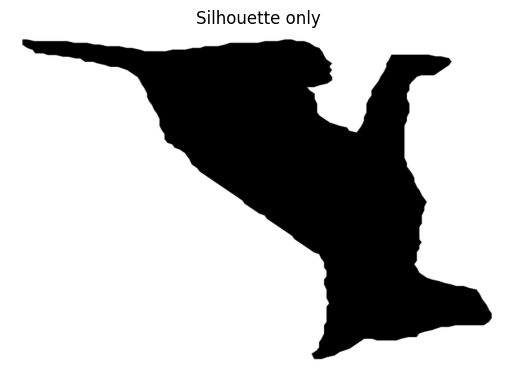

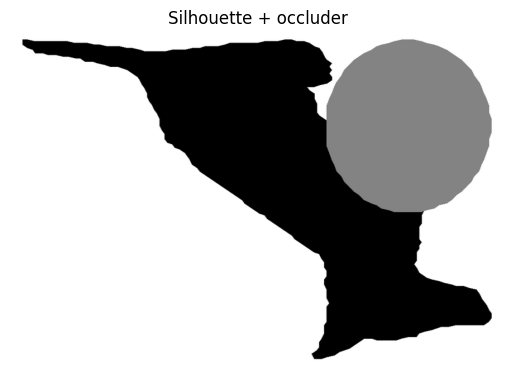

In [36]:
from PIL import Image
import matplotlib.pyplot as plt

def show(path, title):
    im = Image.open(path)
    plt.figure()
    plt.imshow(im)
    plt.title(title)
    plt.axis("off")
    plt.show()

show(imgB, "Silhouette only")
if occluder.size:
    show(imgA, "Silhouette + occluder")


In [37]:
from shape_gen.intersections2 import find_intersection_points_multiple

intersection_points = np.zeros((0, 2), dtype=np.float64)
start_pt = None
end_pt = None

if occluder.size:
    intersection_points = find_intersection_points_multiple(silhouette, occluder, eps_merge=1e-3)

    print("intersection_points shape:", intersection_points.shape)
    print(intersection_points)

    if intersection_points.shape[0] < 2:
        raise RuntimeError("No valid intersection points between silhouette and occluder.")

    start_pt = intersection_points[0, :]
    end_pt = intersection_points[1, :]

    print("start_pt:", start_pt, "end_pt:", end_pt)
else:
    print("Occluder empty. Skipping intersections.")


intersection_points shape: (2, 2)
[[146.  114. ]
 [184.8 167.6]]
start_pt: [146. 114.] end_pt: [184.8 167.6]


In [38]:
import shape_gen.library as lib
import importlib
importlib.reload(lib)

from shape_gen.library import load_master_records, build_class_index

records = load_master_records(MASTER_LIB)
classes, byClass = build_class_index(records)

print("Loaded records:", len(records))
print("Num classes:", len(classes))
print("Example classes:", classes[:10])


Loaded records: 54000
Num classes: 54
Example classes: ['ant', 'bat', 'bear', 'bee', 'beetle', 'bird', 'bug', 'bull', 'butterfly', 'camel']


In [ ]:
from shape_gen.generate3 import generate_completions, save_metadata_jsonl
from shape_gen.heatmap.xy_store import save_xy_npz

# -------------------------------------------------
# Output locations
# -------------------------------------------------
COMPLETIONS_DIR = RAND_DIR
nImages = 10_000   # scale to 100_000 once validated

# -------------------------------------------------
# Run generator (DONOR-BASED, NATURAL SHAPES)
# -------------------------------------------------
metas, out_files_xy, polygons_xy = generate_completions(
    silhouette=silhouette,
    occluder=occluder,
    start_pt=start_pt,
    end_pt=end_pt,
    minX=minX,
    minY=minY,
    wBB=wBB,
    hBB=hBB,
    out_w=W,
    out_h=H,
    out_dir=COMPLETIONS_DIR,
    silhouette_index=1,
    sil_class=sil_class,
    base_grid=baseGrid,
    records=records,
    classes=classes,
    byClass=byClass,
    n_images=nImages,
    rng=rng,
    # refit_enabled=False,
    # snap_intersections_to_vertices=True,
    # --- donor segment sampling ---
    fraction=0.40,              # length of donor fragment

    # --- donor-fit behavior (core inductive bias) ---
    final_n_samples_mode="match_segment",  # preserves donor geometry
    max_attempts_per_image=100,             # resample donors if invalid
    require_valid=True,

    # --- rendering / bookkeeping ---
    supersample=SUPERSAMPLE,
    flush_every=200,
)

# -------------------------------------------------
# Save metadata (JSONL)
# -------------------------------------------------
meta_path = OUT_DIR / "shapes_meta.jsonl"
save_metadata_jsonl(metas, meta_path)

# -------------------------------------------------
# Save XY polygons aligned to inference order
# -------------------------------------------------
xy_path = OUT_DIR / "shapes_xy.npz"
save_xy_npz(
    xy_path,
    out_files=out_files_xy,
    polygons=polygons_xy,
    base_grid=int(baseGrid),
    matlab_1_indexed=True,
)

print("Saved metadata:", meta_path)
print("Saved XY pack:", xy_path)
print("Valid completions saved:", len(out_files_xy))
print("Total meta rows:", len(metas))


Generated 200/10000 completions... (last attempts=2)
Generated 400/10000 completions... (last attempts=3)
Generated 600/10000 completions... (last attempts=1)
Generated 800/10000 completions... (last attempts=3)
Generated 1000/10000 completions... (last attempts=1)
Generated 1200/10000 completions... (last attempts=3)
Generated 1400/10000 completions... (last attempts=1)
Generated 1600/10000 completions... (last attempts=2)
Generated 1800/10000 completions... (last attempts=1)
Generated 2000/10000 completions... (last attempts=9)
Generated 2200/10000 completions... (last attempts=1)
Generated 2400/10000 completions... (last attempts=1)
Generated 2600/10000 completions... (last attempts=1)
Generated 2800/10000 completions... (last attempts=2)
Generated 3000/10000 completions... (last attempts=2)
Generated 3200/10000 completions... (last attempts=5)
Generated 3400/10000 completions... (last attempts=5)
Generated 3600/10000 completions... (last attempts=3)
Generated 3800/10000 completions

In [23]:
# UTILITY . Cell: flip all images in data/generated_images/random_segments by 180 degrees
# (i.e., rotate 180°). Overwrites images by default.
#
# Supported formats: png, jpg, jpeg, bmp, tif, tiff, webp

from pathlib import Path
from PIL import Image

ROOT = Path.cwd().parent  # adjust if needed
IMG_DIR = ROOT / "data" / "generated_images_ant_107" / "completions"

if not IMG_DIR.exists():
    raise FileNotFoundError(f"Directory not found: {IMG_DIR}")

EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff", ".webp"}

paths = [p for p in IMG_DIR.iterdir() if p.is_file() and p.suffix.lower() in EXTS]
print(f"Found {len(paths)} images in {IMG_DIR}")

for p in paths:
    try:
        with Image.open(p) as im:
            # rotate 180° (equivalent to flipping both axes)
            im_rot = im.rotate(180, expand=False)
            im_rot.save(p)
    except Exception as e:
        print(f"Failed on {p.name}: {e}")

print("Done. All images rotated by 180°.")


Found 10000 images in /Users/I743312/Documents/occlusion-study/data/generated_images_ant_107/completions
Done. All images rotated by 180°.
